In [1]:
import javabridge
import os
import glob
import pandas as pd
import pydot
from IPython.display import SVG

In [2]:
tetrad_libdir = os.path.join(os.getcwd(), '../../','src', 'pycausal', 'lib')
for l in glob.glob(tetrad_libdir + os.sep + "*.jar"):
    print l
    javabridge.JARS.append(str(l))

/home/jovyan/py-causal/example/javabridge/../../src/pycausal/lib/causal-cmd-0.2.0-SNAPSHOT.jar
/home/jovyan/py-causal/example/javabridge/../../src/pycausal/lib/tetrad-lib-6.4.0-SNAPSHOT-tetradcmd.jar
/home/jovyan/py-causal/example/javabridge/../../src/pycausal/lib/data-reader-0.2.0-SNAPSHOT.jar


In [3]:
javabridge.start_vm(run_headless=True, max_heap_size = '100M')
javabridge.attach()

In [4]:
def loadContinuousData(df, outputDataset = False):
    tetradData = None

    node_list = javabridge.JClassWrapper("java.util.ArrayList")()
    # load dataset
    for col in df.columns:
        nodi = javabridge.JClassWrapper("edu.cmu.tetrad.data.ContinuousVariable") (col)
        node_list.add(nodi)
    
    dataBox = javabridge.JClassWrapper("edu.cmu.tetrad.data.DoubleDataBox")(len(df.index),df.columns.size)
    
    for col in range(0,df.columns.size):
        for row in df.index:
            value = javabridge.make_instance("java/lang/Double", "(D)V", df.ix[row][col])
            dataBox.set(row,col,value)
    
    tetradData = javabridge.JClassWrapper("edu.cmu.tetrad.data.BoxDataSet")(dataBox, node_list)
    
    if(not outputDataset):
        tetradData = javabridge.JClassWrapper('edu.cmu.tetrad.data.CovarianceMatrixOnTheFly')(tetradData)
        
    return tetradData

In [5]:
datasets = javabridge.JClassWrapper('java.util.ArrayList')()
tetrad_images_dir = os.path.join(os.getcwd(), '../../', 'data', '9var')
for d in glob.glob(tetrad_images_dir + os.sep + "*.txt"):
    print d
    df = pd.read_table(d, sep="\t")
    tetradData = loadContinuousData(df)
    datasets.add(tetradData)

/home/jovyan/py-causal/example/javabridge/../../data/9var/sub016.cent-table.9.dat.txt
/home/jovyan/py-causal/example/javabridge/../../data/9var/sub009.cent-table.9.dat.txt
/home/jovyan/py-causal/example/javabridge/../../data/9var/sub005.cent-table.9.dat.txt
/home/jovyan/py-causal/example/javabridge/../../data/9var/sub010.cent-table.9.dat.txt
/home/jovyan/py-causal/example/javabridge/../../data/9var/sub013.cent-table.9.dat.txt
/home/jovyan/py-causal/example/javabridge/../../data/9var/sub017.cent-table.9.dat.txt
/home/jovyan/py-causal/example/javabridge/../../data/9var/sub014.cent-table.9.dat.txt
/home/jovyan/py-causal/example/javabridge/../../data/9var/sub001.cent-table.9.dat.txt
/home/jovyan/py-causal/example/javabridge/../../data/9var/sub004.cent-table.9.dat.txt


In [6]:
penaltyDiscount = 4
maxDegree = 3
faithfulnessAssumed = True
verbose = True
# numBootstrap = 5
# ensembleMethod = 'Highest'

In [7]:
score = javabridge.JClassWrapper('edu.cmu.tetrad.search.SemBicScoreImages')(datasets)
score.setPenaltyDiscount(penaltyDiscount)

In [8]:
fges = javabridge.JClassWrapper('edu.cmu.tetrad.search.Fges')(score)
fges.setMaxDegree(maxDegree)
fges.setNumPatternsToStore(0)
fges.setFaithfulnessAssumed(faithfulnessAssumed)
fges.setVerbose(verbose)

In [9]:
tetradGraph = fges.search()
tetradGraph

Instance of edu.cmu.tetrad.graph.EdgeListGraphSingleConnections: Graph Nodes:
LOCC,LACC,LIFG,LIPL,ROCC,RACC,RIFG,RIPL,I

Graph Edges:
1. LACC --> RACC 
2. LIFG --> LACC 
3. LIFG --> RIFG 
4. LIPL --- LIFG 
5. LIPL --- LOCC 
6. LIPL --- RIPL 
7. LOCC --- I 
8. RIPL --> RACC 
9. RIPL --> RIFG 
10. ROCC --> LACC 
11. ROCC --- LOCC 

In [10]:
tetradGraph.toString()

u'Graph Nodes:\nLOCC,LACC,LIFG,LIPL,ROCC,RACC,RIFG,RIPL,I\n\nGraph Edges:\n1. LACC --> RACC \n2. LIFG --> LACC \n3. LIFG --> RIFG \n4. LIPL --- LIFG \n5. LIPL --- LOCC \n6. LIPL --- RIPL \n7. LOCC --- I \n8. RIPL --> RACC \n9. RIPL --> RIFG \n10. ROCC --> LACC \n11. ROCC --- LOCC \n'

In [11]:
tetradGraph.getNodeNames()

Instance of java.util.ArrayList: [LOCC, LACC, LIFG, LIPL, ROCC, RACC, RIFG, RIPL, I]

In [12]:
tetradGraph.getEdges()

Instance of java.util.HashSet: [LIPL --- LIFG, LIFG --> LACC, LIPL --- RIPL, RIPL --> RIFG, ROCC --- LOCC, LIPL --- LOCC, ROCC --> LACC, LIFG --> RIFG, LACC --> RACC, RIPL --> RACC, LOCC --- I]

In [13]:
graph = pydot.Dot(graph_type='digraph')

In [14]:
n = tetradGraph.getNodeNames().toString()
n = n[1:len(n)-1]
n = n.split(",")
nodes = []
for i in range(0,len(n)):
    node = n[i]
    n[i] = node.strip()
    print n[i]
    nodes.append(pydot.Node(n[i]))
    graph.add_node(nodes[i])

LOCC
LACC
LIFG
LIPL
ROCC
RACC
RIFG
RIPL
I


In [15]:
def isNodeExisting(nodes,node):
    try:
        nodes.index(node)
        return True
    except IndexError:
        print "Node %s does not exist!", node
        return False

e = tetradGraph.getEdges().toString()
e = e[1:len(e)-1]
e = e.split(",")
for i in range(0,len(e)):
    e[i] = e[i].strip()
    token = e[i].split(" ")
    if(len(token) >= 3):
        src = token[0]
        arc = token[1]
        dst = token[2]
        if(isNodeExisting(n,src) and isNodeExisting(n,dst)):
            edge = pydot.Edge(nodes[n.index(src)],nodes[n.index(dst)])
            if(arc == "---"):
                edge.set_arrowhead("none")
            graph.add_edge(edge)

In [16]:
svg_str = graph.create_svg(prog='dot')

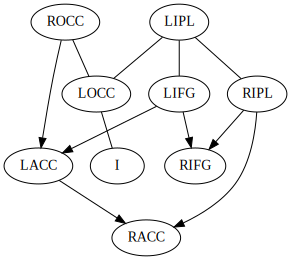

In [17]:
SVG(svg_str)

In [18]:
javabridge.detach()
javabridge.kill_vm()